# Routed Sequencing with Cleanup all Memory

The previous model on "Routed Sequencing with Cleanup Memory" used a scalar ensemble to
project only state **A**. In this model, you will project all the states onto an
ensemble
of neurons as the state cycles through a five element sequence.

In [1]:
# Setup the environment
import numpy as np

import nengo
from nengo import spa  # import spa related packages
from nengo.spa import Vocabulary

## Create the model

This model has parameters as described in the book. It extends the routed sequencing
model by creating a scalar ensemble `cleanup` and then projecting all the states on to
this ensemble using a transformation matrix `pd`, specified by the vectors in the
vocabulary.

In [2]:
# Number of dimensions for the Semantic Pointers
dim = 16

# Change the seed of this RNG to change the vocabulary
rng = np.random.RandomState(4)
vocab = Vocabulary(dimensions=dim, rng=rng, max_similarity=0.1)

# Make a model object with the SPA network
model = spa.SPA(label="Routed_Sequence with cleanupAll", vocabs=[vocab])

with model:
    # Specify the modules to be used
    model.state = spa.State(dimensions=dim, feedback=1, feedback_synapse=0.01)
    model.vision = spa.State(dimensions=dim)
    # Specify the action mapping
    actions = spa.Actions(
        "dot(vision, START) --> state = vision",
        "dot(state, A) --> state = B",
        "dot(state, B) --> state = C",
        "dot(state, C) --> state = D",
        "dot(state, D) --> state = E",
        "dot(state, E) --> state = A",
    )

    # Creating the BG and thalamus components that confirm to the specified rules
    model.bg = spa.BasalGanglia(actions=actions)
    model.thal = spa.Thalamus(model.bg)

    # Get vocabulary items in order of creation
    vsize = len((model.get_output_vocab("state").keys))
    vocab_items = []
    for index in range(vsize):
        vocab_items.append(model.get_output_vocab("state").keys[index])

    # Creating the transformation matrix (pd) and cleanup SPA State (cleanup)
    pd = []
    for item in vocab_items:
        pd.append([model.get_output_vocab("state")[item].v.tolist()])

    model.cleanup = nengo.Ensemble(n_neurons=300, dimensions=vsize)

    # Function that provides the model with an initial input semantic pointer.
    def start(t):
        if t < 0.4:
            return "0.8*START+D"
        return "0"

    # Input
    model.input = spa.Input(vision=start)

    # Projecting the state to the cleanup ensemble using a transformation matrix 'pd'.
    # Note that the first item in the vocabulary (`START`) is ignored.
    for i in range(1, vsize):
        nengo.Connection(model.state.output, model.cleanup[i], transform=pd[i])

## Run the model

In [ ]:
# Import the nengo_gui visualizer to run and visualize the model.
from nengo_gui.ipython import IPythonViz

IPythonViz(model, "ch7-spa-sequence-routed-cleanup-all.py.cfg")

Press the play button in the visualizer to run the simulation. You should see the graphs
as shown in the figure below.

The graph in the middle shows the semantic pointer representation of the values stored
in `state` and the plot on the bottom-right shows the response of the `cleanup`
population. and the graph on the top-right shows the utility (similarity) of the current
Basal Ganglia input (i.e., `state`) with the possible vocabulary vectors.

Since the cleanup operation is similar to a dot product between the state and the
defined vocabulary vectors, the value of the `cleanup` population in a particular
dimension rises only when the value of `state` (top-right graph) corresponds to that
particular dimension.

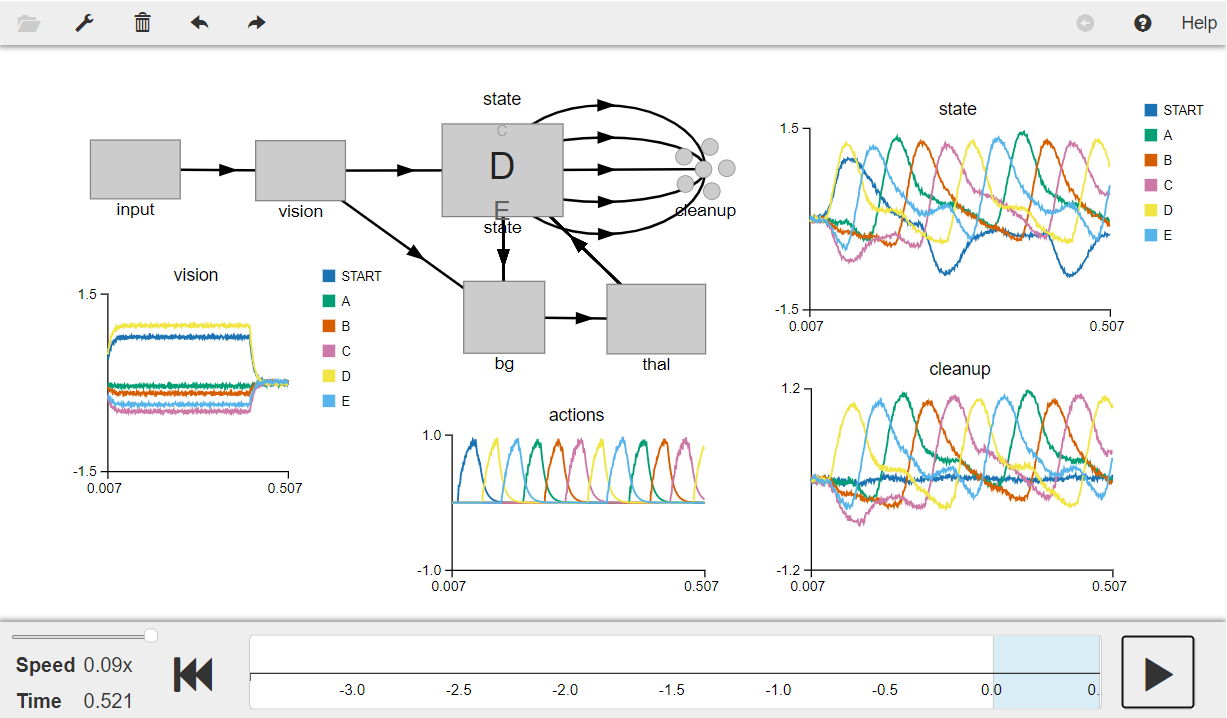

In [3]:
from IPython.display import Image

Image(filename="ch7-spa-sequence-routed-cleanup-all.png")